# NESTML dopamine-modulated STDP synapse tutorial

<i>Some text in this this section is copied verbatim from [1].</i>

Pavlov and Thompson (1902) firs described classical conditioning: a phenomenon in which a biologically potent stimulus–the Unconditional Stimulus (UC)—is initially paired with a neutral stimulus—the Conditional Stimulus CS). After many trials, learning is observed when the previously neutral stimuli starts to elicit a response similar to that which was previously only elicited by the biologically potent stimulus. Pavlov and Thompson performed many experiments with dogs, observing their response (by monitoring salivation) to the appearance of a person who has been feeding them and the actual food appearing (UC). He demonstrated that the dogs started to salivate in the presence of the person who has been feeding them (or any other CS), rather than just when the food appears, because the CS had previously been associated with food.

## Model

Izhikevich (2007) revisits an important question: how does an
animal know which of the many cues and actions preceding a
reward should be credited for the reward? Izhikevich explains
that dopamine-modulated STDP has a built-in instrumental
conditioning property, i.e., the associations between cues, actions
and rewards are learned automatically by reinforcing the firing
patterns (networks of synapses) responsible, even when the
firings of those patterns are followed by a delayed reward or
masked by other network activity. To achieve this each synapse
has an eligibility trace C:

$$
\frac{dC}{dt} = -\frac{C}{\tau_C} + \text{STDP}(\Delta t)\delta(t - t_\text{pre/post}) \quad \text{(1)}
$$

where τc is the decay time constant of the eligibility trace and
$\text{STDP}(\Delta t)$ represents the magnitude of the change to make to the
eligibility trace in response to a pair of pre- and post-synaptic
spikes with temporal difference $\Delta t = t_\text{post} − t_\text{pre}$. Finally, $\delta(t − t_\text{pre/post})$ is a Dirac delta function used to apply the effect of STDP to the trace at the times of pre- or post-synaptic spikes. The concentration of Dopamine is described by a variable $D$:

$$
\frac{dD}{dt} = − \frac{D}{\tau_d} + D_c \sum_{t_d^f} \delta(t - t_d^f) \quad \text{(2)}
$$

where $\tau_d$ is the time constant of dopamine re-absorption, $D_c$ is
the increase in dopamine concentration caused by each incoming
dopaminergic spike and $t_d^f$ are the times of these spikes.
Equations (1, 2) are then combined to calculate the change in
synaptic strength W:
$$
\frac{dW}{dt} = CD  \quad \text{(3)}
$$

As discussed in section 1, when a post-synaptic spike arrives
very shortly after a pre-synaptic spike, a standard STDP rule
would immediately potentiate the synaptic strength. However,
as Figure 2 illustrates, when using the three-factor STDP rule,this potentiation would instead be applied to the eligibility trace.
Because changes to the synaptic strength are gated by dopamine
concentration $D$ (Equation 4), changes are only made to the
synaptic strength if $D \neq 0$. Furthermore, if the eligibility trace
has decayed back to 0 before any dopaminergic spikes arrive, the
synaptic strength will not be changed


<img src="network_diagram.png" alt="Network diagram" width="50%">

<small><i>Figure from [2]</i></small>


In [71]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import re
from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential.

We now define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse0__with_iaf_psc_delta0" and "iaf_psc_delta0__with_stdp_synapse0".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

In [72]:
n_modules_generated = 0
def generate_code_for(nestml_synapse_model: str):
    """Generate code for a given synapse model, passed as a string, in combination with
    the iaf_psc_delta model.
    
    NEST cannot yet reload modules. Workaround using counter to generate unique names."""
    global n_modules_generated
   
    # append digit to the neuron model name and neuron model filename
    with open("models/neurons/iaf_psc_delta.nestml", "r") as nestml_model_file_orig:
        nestml_neuron_model = nestml_model_file_orig.read()
        nestml_neuron_model = re.sub("neuron\ [^:\s]*:",
                                     "neuron iaf_psc_delta" + str(n_modules_generated) + ":", nestml_neuron_model)
        with open("models/neurons/iaf_psc_delta" + str(n_modules_generated) + ".nestml", "w") as nestml_model_file_mod:
            print(nestml_neuron_model, file=nestml_model_file_mod)

    # append digit to the synapse model name and synapse model filename
    nestml_synapse_model_name = re.findall("synapse\ [^:\s]*:", nestml_synapse_model)[0][8:-1]
    nestml_synapse_model = re.sub("synapse\ [^:\s]*:",
                                  "synapse " + nestml_synapse_model_name + str(n_modules_generated) + ":", nestml_synapse_model)
    with open("models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml", "w") as nestml_model_file:
        print(nestml_synapse_model, file=nestml_model_file)

    # generate the code for neuron and synapse (co-generated)
    module_name = "nestml_" + str(n_modules_generated) + "_module"
    generate_nest_target(input_path=["models/neurons/iaf_psc_delta" + str(n_modules_generated) + ".nestml",
                                     "models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml"],
                         target_path="/tmp/nestml_module",
                         logging_level="ERROR",
                         module_name=module_name,
                         suffix="_nestml",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION,
                                       "neuron_parent_class": "StructuralPlasticityNode",
                                       "neuron_parent_class_include": "structural_plasticity_node.h",
                                       "neuron_synapse_pairs": [{"neuron": "iaf_psc_delta" + str(n_modules_generated),
                                                                   "synapse": nestml_synapse_model_name + str(n_modules_generated),
                                                                   "post_ports": ["post_spikes"],
                                                                   "vt_ports": ["mod_spikes"]}]})
    
    # load module into NEST
    nest.ResetKernel()
    nest.Install(module_name)

    mangled_neuron_name = "iaf_psc_delta" + str(n_modules_generated) + "_nestml__with_" + nestml_synapse_model_name + str(n_modules_generated) + "_nestml"
    mangled_synapse_name = nestml_synapse_model_name + str(n_modules_generated) + "_nestml__with_iaf_psc_delta" + str(n_modules_generated) + "_nestml"

    n_modules_generated += 1
    
    return mangled_neuron_name, mangled_synapse_name

We now go on to define the full synapse model in NESTML:

In [3]:
nestml_stdp_dopa_model = """
synapse neuromodulated_stdp:

  state:
    w real = 1.
    n real = 0.   # Neuromodulator concentration
    c real = 0.   # Eligibility trace
    pre_tr real = 0.
    post_tr real = 0.
  end

  parameters:
    the_delay ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    tau_tr_pre ms = 20 ms   # STDP time constant for weight changes caused by pre-before-post spike pairings.
    tau_tr_post ms = 20 ms    # STDP time constant for weight changes caused by post-before-pre spike pairings.
    tau_c ms = 1000 ms    # Time constant of eligibility trace
    tau_n ms = 200 ms   # Time constant of dopaminergic trace
    b real = 0.   # Dopaminergic baseline concentration
    Wmax real = 200.    # Maximal synaptic weight
    Wmin real = 0.    # Minimal synaptic weight
    A_plus real = 1.    # Multiplier applied to weight changes caused by pre-before-post spike pairings. If b (dopamine baseline concentration) is zero, then A_plus is simply the multiplier for facilitation (as in the stdp_synapse model). If b is not zero, then A_plus will be the multiplier for facilitation only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_plus will be the multiplier for depression.
    A_minus real = 1.5    # Multiplier applied to weight changes caused by post-before-pre spike pairings. If b (dopamine baseline concentration) is zero, then A_minus is simply the multiplier for depression (as in the stdp_synapse model). If b is not zero, then A_minus will be the multiplier for depression only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_minus will be the multiplier for facilitation.
    A_vt real = 1.     # Multiplier applied to dopa spikes
  end

  equations:
    pre_tr' = -pre_tr / tau_tr_pre
    post_tr' = -post_tr / tau_tr_post
  end

  internals:
    tau_s 1/ms = (tau_c + tau_n) / (tau_c * tau_n)
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
    mod_spikes real <- spike
  end

  output: spike

  onReceive(mod_spikes):
    n += A_vt / tau_n
  end

  onReceive(post_spikes):
    post_tr += 1.

    # facilitation
    c += A_plus * pre_tr
  end

  onReceive(pre_spikes):
    pre_tr += 1.

    # depression
    c -= A_minus * post_tr

    # deliver spike to postsynaptic partner
    deliver_spike(w, the_delay)
  end

  # update from time t to t + resolution()
  update:
    # resolution() returns the timestep to be made (in units of time)
    # the sequence here matters: the update step for w requires the "old" values of c and n
    w -= c * ( n / tau_s * expm1( -tau_s * resolution() ) \
             - b * tau_c * expm1( -resolution() / tau_c ))
    c = c * exp(-resolution() / tau_c)
    n = n * exp(-resolution() / tau_n)
  end

end
"""

Generate the code, build the user module and make the model available to instantiate in NEST:

In [4]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_stdp_dopa_model)

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [46]:
def run_network(pre_spike_time, post_spike_time, vt_spike_times,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=.1, # [ms]
                          delay=1., # [ms]
                          lmbda=1E-6,
                          sim_time=None,  # if None, computed from pre and post spike times
                          synapse_parameters=None,  # optional dictionary passed to the synapse
                          fname_snip=""):

    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time]})
    vt_sg = nest.Create("spike_generator",
                            params={"spike_times": vt_spike_times})

    # create  volume transmitter
    vt = nest.Create("volume_transmitter")
    vt_parrot = nest.Create("parrot_neuron")
    nest.Connect(vt_sg, vt_parrot, syn_spec={"weight": -1.})
    nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                          "weight": 1.,
                                          "delay": 1.})   # delay is ignored?!
    vt_gid = vt.get("global_id")

    # set up custom synapse models
    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "w": 1.,
                 "delay": delay,
                 #"d": delay,
                 "receptor_type": 0,
#                  "mu_minus": 0.,
#                  "mu_plus": 0.
                 "vt": vt_gid,
                 "tau_tr_pre": 10.,
                 "A_vt": 1.
                })

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)
    
    var_name = [s for s in post_neuron.get().keys() if s.startswith("post_tr")][0]
    
    post_neuron.set({var_name: 10.})

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    spikedet_vt = nest.Create("spike_recorder")

    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)
    nest.Connect(vt_parrot, spikedet_vt)

    
    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    #synapse_parameters.update({"lambda": lmbda})
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["w"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["w"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    #print("Actual pre spike times: " + str(pre_spike_times_))
    assert len(pre_spike_times_) == 1 and pre_spike_times_[0] > 0
    
    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    #print("Actual post spike times: " + str(post_spike_times_))
    assert len(post_spike_times_) == 1 and post_spike_times_[0] > 0

    vt_spike_times_ = nest.GetStatus(spikedet_vt, "events")[0]["times"]
    #print("Actual vt spike times: " + str(vt_spike_times_))
    assert len(vt_spike_times_) == 1 and vt_spike_times_[0] > 0

    #dt = actual_t_post_sp - actual_t_pre_sp
    dt = 0.
    dw = updated_weight

    return dt, dw

Then, we can run the experiment. We set the pre spike time to a constant (100 ms) and loop over values for the post spike time (25 to 175 ms).

Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay. Hint: play with the parameters a bit here and see the effects it has on the returned window.

In [57]:
def plot_vt_spike_timing_experiment(dt_vec, dw_vec, delay, pre_spike_times_, post_spike_times_, vt_spike_times_):
    fig, ax = plt.subplots(nrows=4)
    ax1, ax2, ax3, ax4 = ax

    n_spikes = len(pre_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax1.plot(2 * [pre_spike_times_[i] + delay], [0, 1], linewidth=2, color="blue", alpha=.4, label=_lbl)

    ax1.set_ylabel("Pre spikes")

    ax2.plot(timevec, nest.GetStatus(mm, "events")[
             0]["post_tr__for_neuromodulated_stdp_nestml"], label="nestml post tr")
    n_spikes = len(post_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax2.plot(2 * [post_spike_times_[i]], [0, 1], linewidth=2, color="black", alpha=.4, label=_lbl)
    ax2.set_ylabel("Post spikes")

    n_spikes = len(vt_spike_times_)
    for i in range(n_spikes):
        ax3.plot(2 * [vt_spike_times_[i]], [0, 1], linewidth=2, color="black", alpha=.4)
    ax3.set_ylabel("VT spikes")

    ax4.plot(t_hist, w_hist, marker="o", label="nestml")
    ax4.set_xlabel("Time [ms]")
    ax4.set_ylabel("w")

    for _ax in ax:
        _ax.grid(which="major", axis="both")
        _ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0, np.ceil(sim_time))))
        _ax.set_xlim(0., sim_time)
        _ax.legend()
    fig.show()

In [73]:
def run_vt_spike_timing_experiment(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 10000.  # [ms] -- make sure to simulate for much longer than the eligibility trace
                      #         time constant, which is typically the slowest time constant in 
                      #         the system, PLUS the time of the latest vt spike
    pre_spike_time = 1. # [ms]
    post_spike_time = 3. # [ms]
    delay = .5 # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for vt_spike_time in np.round(np.linspace(4, 5000, 12)).astype(float):  # sim_time - 10 * delay
        dt, dw = run_network(pre_spike_time, post_spike_time, [vt_spike_time],
                          neuron_model_name,
                          synapse_model_name,
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(vt_spike_time)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [5.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [459.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [913.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [1368.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [1822.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [2276.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [2730.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [3184.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [3638.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [4093.]
Actual pre spike times: [2.]
Actual post spike times: [4.]
Actual vt spike times: [4547.]
Actual pre spik

Text(0, 0.5, 'Weight at $t = \\infty$')

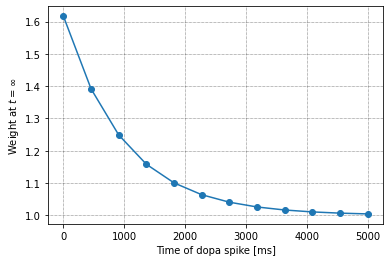

In [75]:
dt_vec, dw_vec, delay = run_vt_spike_timing_experiment(neuron_model_name, synapse_model_name)

fig, ax = plt.subplots()
ax.plot(dt_vec, dw_vec, marker='o')
ax.set_xlabel("Time of dopa spike [ms]")
ax.set_ylabel("Weight at $t = \infty$")

#plot_vt_spike_timing_experiment(dt_vec, dw_vec, delay)

Noisy Cue-Association: Temporal Credit-Assignment Task
----------------------

...

Citations
---------

[1] Mikaitis M, Pineda García G,
Knight JC and Furber SB (2018)
Neuromodulated Synaptic Plasticity
on the SpiNNaker Neuromorphic
System. Front. Neurosci. 12:105.
doi: 10.3389/fnins.2018.00105

[2] PyGeNN: A Python library for GPU-enhanced neural networks, James C Knight 1,∗, Anton Komissarov 2,3, Thomas Nowotny 1, Frontiers


Acknowledgements
----------------

...

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.